In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import numpy as np

images = np.load("/content/drive/MyDrive/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/content/drive/MyDrive/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


In [4]:
data = np.column_stack((images, masks, labels))
data.shape

(3064, 3)

In [5]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.08, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.12, random_state=42)

print("Train:", train_data.shape,
      "\nVal:", val_data.shape,
      "\nTest:", test_data.shape,)

Train: (2479, 3) 
Val: (246, 3) 
Test: (339, 3)


In [6]:
import cv2

def data_to_viz(data, label, n=5):


    expected_index = np.where(data[:,2] == label)
    expected_data = data[expected_index]


    index = np.random.choice(expected_data.shape[0], n, replace=False)
    data_to_viz = expected_data[index]

    imgs = []
    masks = []
    labels = []
    for data_i in data_to_viz:

        # img
        imgs.append(cv2.resize(data_i[0], (512, 512)))

        # mask
        masks.append(cv2.resize(data_i[1].astype("uint8"),
                                (512, 512)))

        # label
        labels.append(data_i[2])

    return np.hstack(imgs), np.hstack(masks), labels

In [7]:
meningiomas_imgs, meningiomas_masks, meningiomas_labels = data_to_viz(data, label=1, n=5)
glioma_imgs, glioma_masks, glioma_labels  = data_to_viz(data, label=2, n=5)
tumor_imgs, tumor_masks, tumor_labels = data_to_viz(data, label=3, n=5)

print("Meningiomas:",
      meningiomas_imgs.shape, meningiomas_masks.shape, meningiomas_labels)
print("Glioma:",
      glioma_imgs.shape, glioma_masks.shape, glioma_labels)
print("Pituitary Tumor:",
      tumor_imgs.shape, tumor_masks.shape, tumor_labels)

Meningiomas: (512, 2560) (512, 2560) [1, 1, 1, 1, 1]
Glioma: (512, 2560) (512, 2560) [2, 2, 2, 2, 2]
Pituitary Tumor: (512, 2560) (512, 2560) [3, 3, 3, 3, 3]


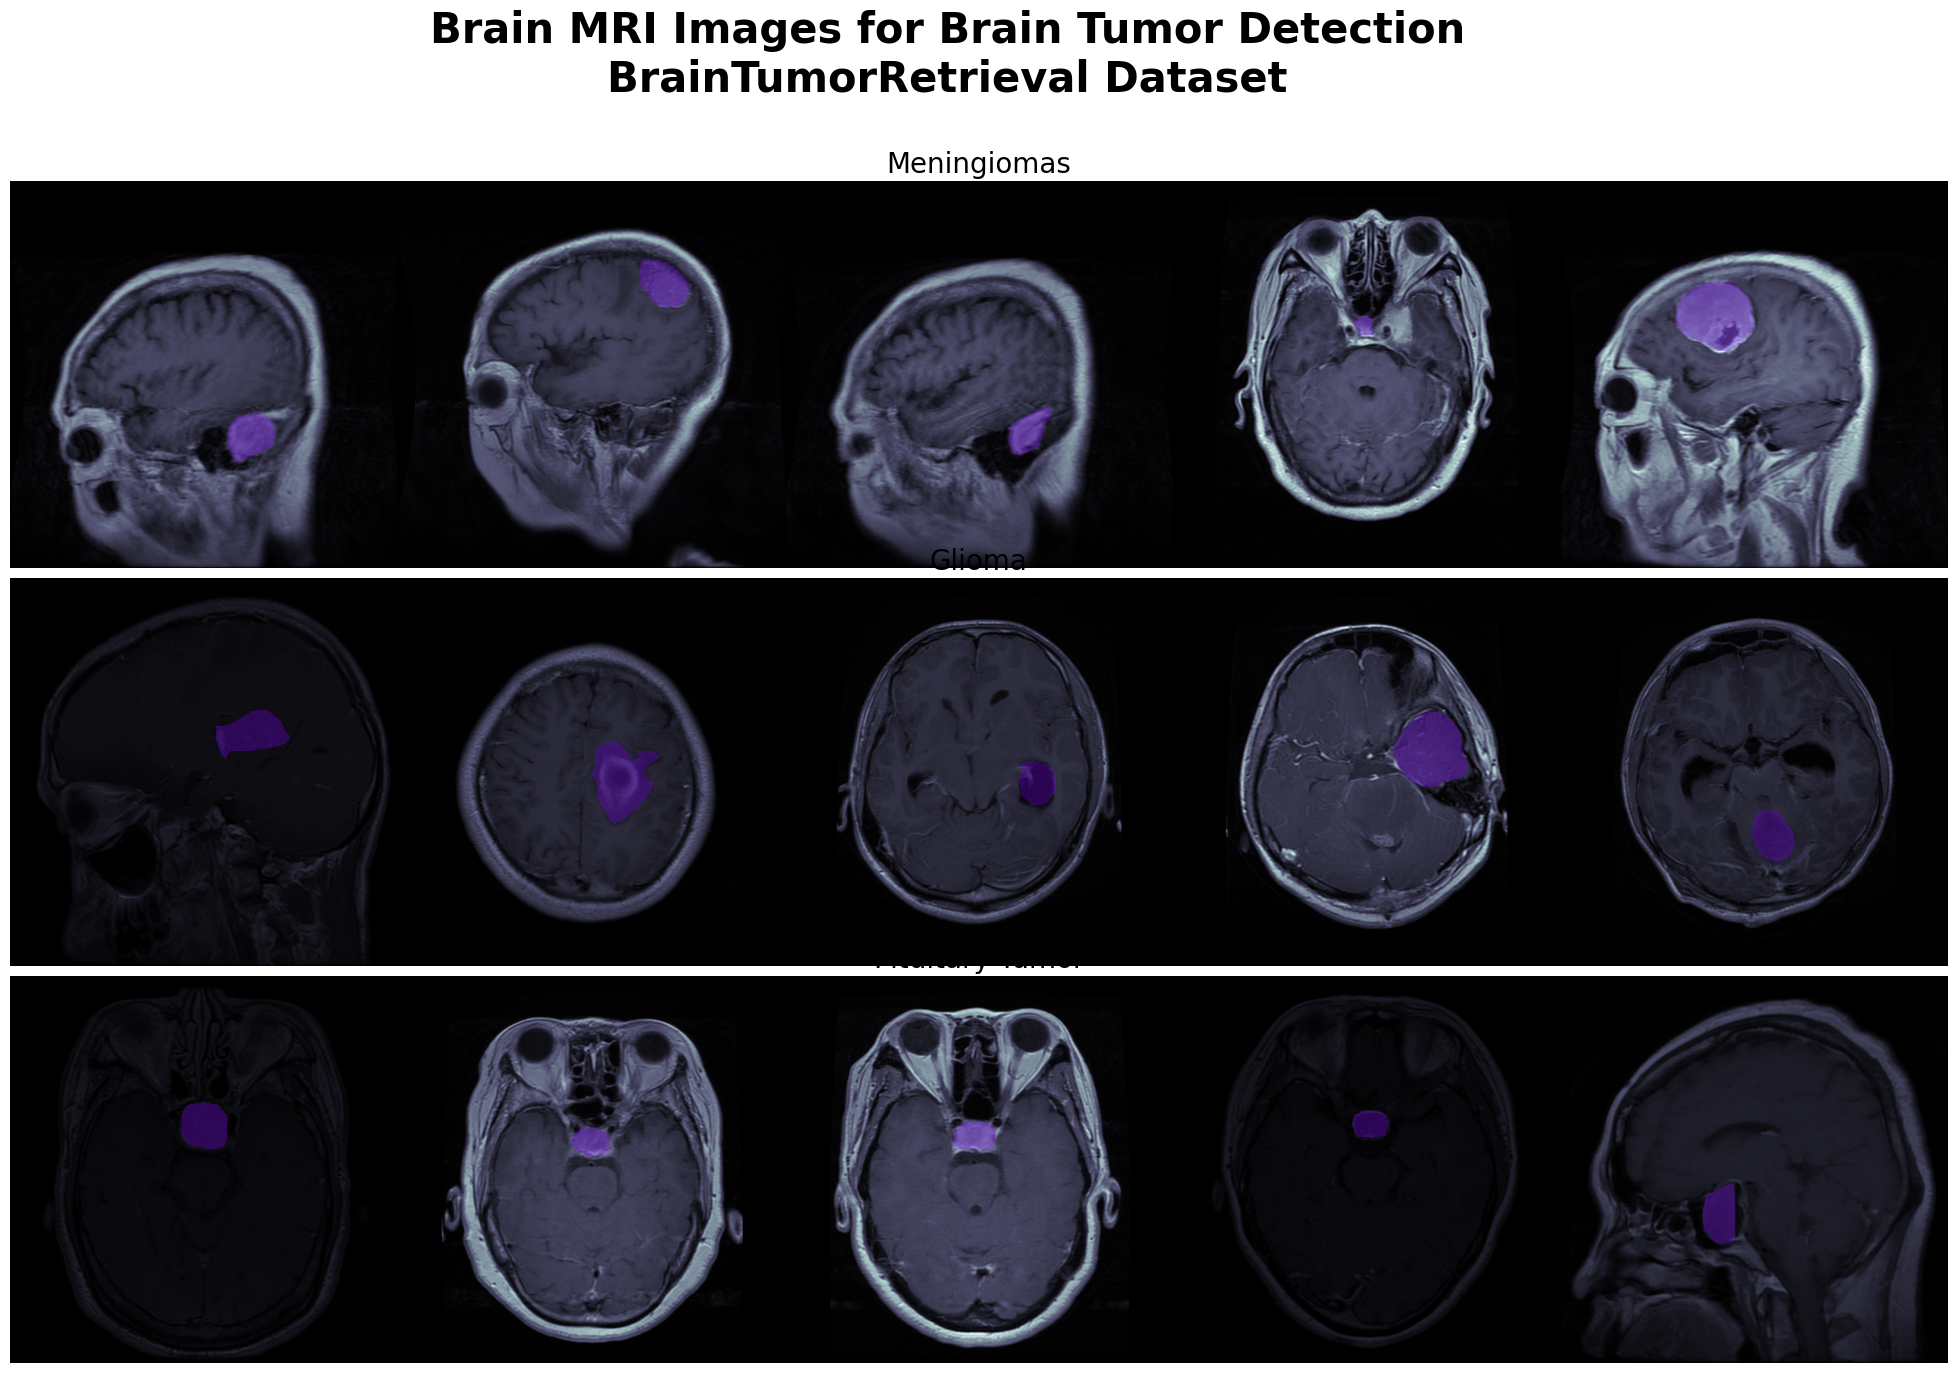

In [8]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 1),
                 axes_pad=0.1,
                 )


grid[0].imshow(meningiomas_imgs, cmap="bone")
grid[0].imshow(np.ma.masked_where(meningiomas_masks == False,
                                  meningiomas_masks), cmap='rainbow', alpha=0.3)

grid[0].set_title("Meningiomas", fontsize=20)
grid[0].axis("off")

grid[1].imshow(glioma_imgs, cmap="bone")
grid[1].imshow(np.ma.masked_where(glioma_masks == False,
                                  glioma_masks), cmap='rainbow', alpha=0.3)
grid[1].set_title("Glioma", fontsize=20)
grid[1].axis("off")

grid[2].imshow(tumor_imgs, cmap="bone")
grid[2].imshow(np.ma.masked_where(tumor_masks == False,
                                  tumor_masks), cmap='rainbow', alpha=0.3)

grid[2].set_title("Pituitary Tumor", fontsize=20)
grid[2].axis("off")


# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nBrainTumorRetrieval Dataset",
             y=.80, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", pad_inches=0.2, transparent=True)
plt.show()


# Datataset and DataGenerator

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
class BrainMriDataset(Dataset):
    def __init__(self, data, transforms, n_classes=3):

        self.data = data
        self.transforms = transforms
        self.n_classes = n_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image = self.data[idx][0].astype("float32")


        mean, std = image.mean(), image.std()
        image = (image - mean) / std


        image_rgb = np.stack([image]*3).transpose(1,2,0)

        label = self.data[idx][2] -1
        mask = np.expand_dims(self.data[idx][1], -1)

        target_mask = np.zeros((mask.shape[0], mask.shape[1],
                                self.n_classes))
        target_mask[:,:, label : label + 1] = mask.astype("uint8")


        target_mask = np.clip(target_mask, 0, 1).astype("float32")

        augmented = self.transforms(image=image_rgb,
                                    mask=target_mask)
        image = augmented['image']
        mask = augmented['mask']

        return image, mask

In [11]:
# Data augmentation
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=45, shift_limit=0.1, p=0.5, border_mode=0),
    A.GridDistortion(p=0.5),
    A.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
    A.ElasticTransform(p=0.5, alpha=1, sigma=50, alpha_affine=None),  # Fixed alpha_affine
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(156, 156, p=1.),
    A.RandomCrop(128, 128, p=1.)
])


In [12]:
# train
train_dataset = BrainMriDataset(data=train_data, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4,
                              shuffle=True)

# validation
val_dataset = BrainMriDataset(data=val_data, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4,
                            shuffle=True)

# test
test_dataset = BrainMriDataset(data=test_data, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=4,
                             shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([16, 128, 128, 3]) torch.Size([16, 128, 128, 3])


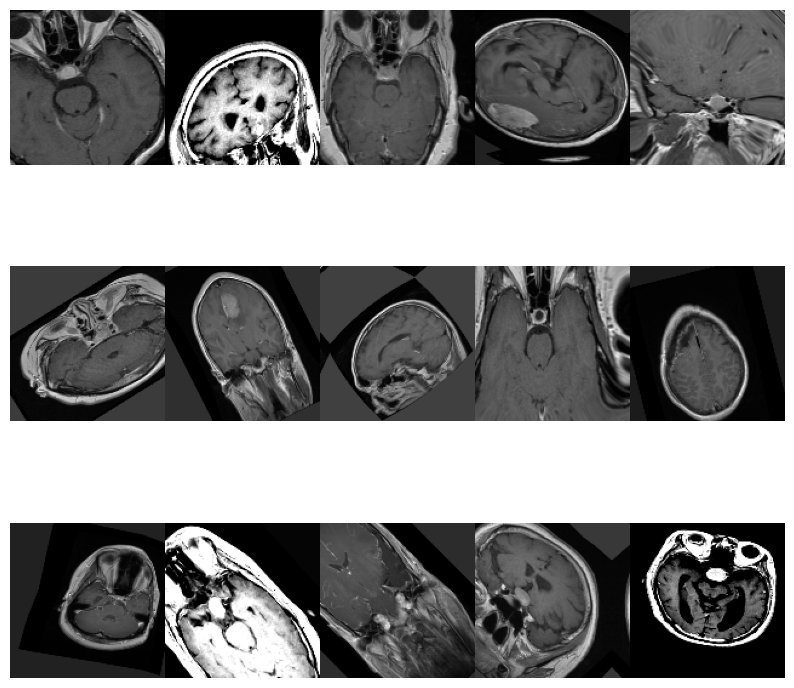

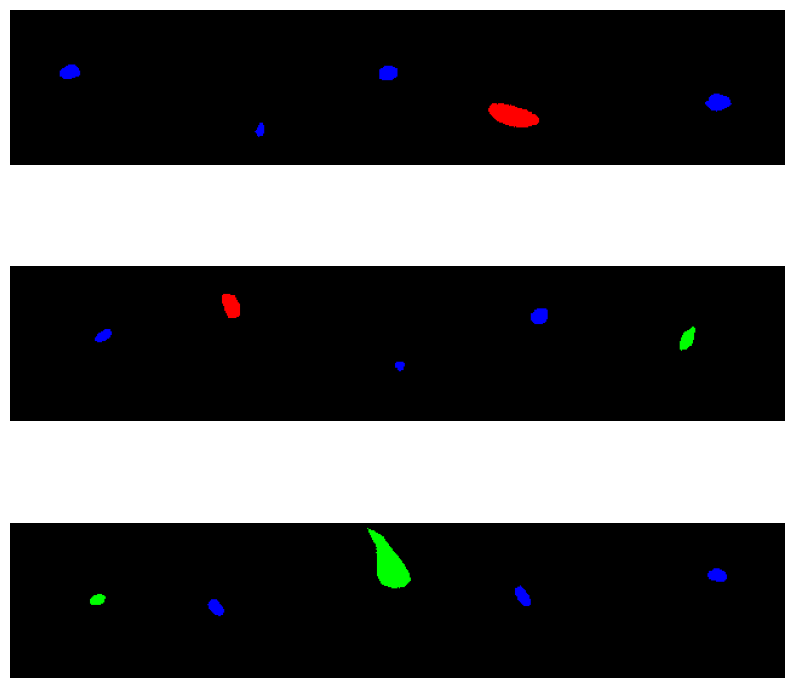

In [13]:
def show_aug(inputs, nrows=3, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0

    if len(inputs) > 15:
        inputs = inputs[:15]

    for idx in range(len(inputs)):

        # normalization
        if image is True:
            img = inputs[idx].numpy()#.transpose(1,2,0)
            img = (img - img.min()) / (img.max() - img.min())  # normalize to [0, 1]
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]

        #plot
        #print(img.max(), len(np.unique(img)), img.mean())
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img);
        plt.axis('off')

        i_ += 1

    return plt.show()

images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks)


V-Net Model

In [ ]:
from torchvision.models import resnext50_32x4d

# U-Net model architecture with ResNeXt50 backbone and dropout
class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()
        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convrelu(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        return self.conv2(x)

class p(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4 * 64, 4 * 128, 4 * 256, 4 * 512]

        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.dropout = nn.Dropout(0.5)

        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)

    def forward(self, x):
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        d1 = self.dropout(d1)
        out = self.last_conv0(d1)
        out = self.last_conv1(out)

        return torch.sigmoid(out)

In [19]:
# Loss functions and metrics
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection / union

def dice_coef_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)
    return bceloss + dicescore


import torch.optim as optim
# Model initialization
model = ResNeXtUNet(n_classes=3).to(device)

# Optimizer and learning rate scheduler
adamw = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # AdamW optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(adamw, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop
def train_one_epoch(model, optimizer, lr_scheduler, data_loader, epoch):
    model.train()
    losses = []
    accur = []
    for data, target in data_loader:
        data = data.permute(0, 3, 1, 2).to(device)
        targets = target.permute(0, 3, 1, 2).to(device)
        outputs = model(data)
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[out_cut < 0.5] = 0.0
        out_cut[out_cut >= 0.5] = 1.0
        train_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())
        loss = bce_dice_loss(outputs, targets)
        losses.append(loss.item())
        accur.append(train_dice)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if lr_scheduler is not None:
        lr_scheduler.step(np.array(losses).mean())
    print(f"Epoch [{epoch}]: Loss={np.array(losses).mean()}, DICE={np.array(accur).mean()}")
    return np.array(losses).mean(), np.array(accur).mean()



In [20]:
# Define validation function
def val_epoch(model, data_loader, epoch):
    print("Start Validation ...")
    model.eval()

    val_losses = []
    val_dices = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.permute(0, 3, 1, 2).to(device)
            targets = target.permute(0, 3, 1, 2).to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            val_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())
            loss = bce_dice_loss(outputs, targets)

            val_losses.append(loss.item())
            val_dices.append(val_dice)

    print("Epoch [%d]" % (epoch))
    print("Mean loss on validation:", np.array(val_losses).mean(), "Mean DICE on validation:", np.array(val_dices).mean())

    return np.array(val_dices).mean()


In [21]:


# Setup optimizer and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNeXtUNet(n_classes=3).to(device)
adamw = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(adamw, mode='min', factor=0.1, patience=5)

# Training loop
weights_dir = "weights"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

num_epochs = 30
loss_history = []
train_dice_history = []
val_dice_history = []

for epoch in trange(num_epochs):
    loss, train_dice = train_one_epoch(model, adamw, scheduler, train_dataloader, epoch)
    val_dice = val_epoch(model, val_dataloader, epoch)

    loss_history.append(loss)
    train_dice_history.append(train_dice)
    val_dice_history.append(val_dice)

    best_dice = max(val_dice_history)
    if val_dice >= best_dice:
        torch.save({'state_dict': model.state_dict()},
                   os.path.join(weights_dir, f"{val_dice:0.5f}_.pth"))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [0]: Loss=1.020885750939769, DICE=0.0061280785300560385
Start Validation ...
Epoch [0]
Mean loss on validation: 0.8594222441315651 Mean DICE on validation: 0.06040361744536979


  3%|▎         | 1/30 [04:38<2:14:37, 278.54s/it]

Epoch [1]: Loss=0.7448869170681123, DICE=0.34783752940029516
Start Validation ...
Epoch [1]
Mean loss on validation: 0.6635728776454926 Mean DICE on validation: 0.48115317233474186


  7%|▋         | 2/30 [09:10<2:08:07, 274.54s/it]

Epoch [2]: Loss=0.610479760554529, DICE=0.5089608047235902
Start Validation ...
Epoch [2]
Mean loss on validation: 0.5669868420809507 Mean DICE on validation: 0.5273423127847485


 10%|█         | 3/30 [13:44<2:03:24, 274.25s/it]

Epoch [3]: Loss=0.5308608278151481, DICE=0.5687417439777633
Start Validation ...
Epoch [3]
Mean loss on validation: 0.48632104881107807 Mean DICE on validation: 0.6017993731998157


 13%|█▎        | 4/30 [18:24<1:59:55, 276.77s/it]

Epoch [4]: Loss=0.43895992655907906, DICE=0.6514274668448669
Start Validation ...
Epoch [4]
Mean loss on validation: 0.401595713570714 Mean DICE on validation: 0.6611102720072966


 17%|█▋        | 5/30 [23:03<1:55:39, 277.58s/it]

Epoch [5]: Loss=0.38759586215019226, DICE=0.674332290751328
Start Validation ...
Epoch [5]
Mean loss on validation: 0.39164842292666435 Mean DICE on validation: 0.6719720602308878


 20%|██        | 6/30 [27:43<1:51:16, 278.17s/it]

Epoch [6]: Loss=0.380187992318984, DICE=0.6883642024914901
Start Validation ...


 23%|██▎       | 7/30 [32:30<1:47:48, 281.22s/it]

Epoch [6]
Mean loss on validation: 0.38657025061547756 Mean DICE on validation: 0.6669604113277483
Epoch [7]: Loss=0.35002795409771703, DICE=0.7105566876439866
Start Validation ...
Epoch [7]
Mean loss on validation: 0.3664412200450897 Mean DICE on validation: 0.6839530682989393


 27%|██▋       | 8/30 [37:15<1:43:30, 282.29s/it]

Epoch [8]: Loss=0.3309846673280962, DICE=0.7255560879752873
Start Validation ...
Epoch [8]
Mean loss on validation: 0.3162612896412611 Mean DICE on validation: 0.7549956480871012


 30%|███       | 9/30 [41:58<1:38:53, 282.53s/it]

Epoch [9]: Loss=0.3249167307730644, DICE=0.737788171345541
Start Validation ...


 33%|███▎      | 10/30 [46:26<1:32:44, 278.24s/it]

Epoch [9]
Mean loss on validation: 0.33013799879699945 Mean DICE on validation: 0.7364769644190281
Epoch [10]: Loss=0.32843365967273713, DICE=0.7238446331410912
Start Validation ...


 37%|███▋      | 11/30 [51:05<1:28:10, 278.46s/it]

Epoch [10]
Mean loss on validation: 0.37029382213950157 Mean DICE on validation: 0.6935977289816999
Epoch [11]: Loss=0.31313984874756107, DICE=0.7412269205820069
Start Validation ...


 40%|████      | 12/30 [55:40<1:23:13, 277.43s/it]

Epoch [11]
Mean loss on validation: 0.3561560306698084 Mean DICE on validation: 0.7201361186932649
Epoch [12]: Loss=0.3238405329565848, DICE=0.7244845676558886
Start Validation ...


 43%|████▎     | 13/30 [1:00:31<1:19:41, 281.27s/it]

Epoch [12]
Mean loss on validation: 0.35605554934591055 Mean DICE on validation: 0.6909019003202387
Epoch [13]: Loss=0.31084514625610843, DICE=0.7391594899004956
Start Validation ...
Epoch [13]
Mean loss on validation: 0.2862615864723921 Mean DICE on validation: 0.7708453301388295


 47%|████▋     | 14/30 [1:05:11<1:14:57, 281.12s/it]

Epoch [14]: Loss=0.287191968002627, DICE=0.7535604152476284
Start Validation ...


 50%|█████     | 15/30 [1:09:50<1:10:03, 280.25s/it]

Epoch [14]
Mean loss on validation: 0.29631567280739546 Mean DICE on validation: 0.7394850563391662
Epoch [15]: Loss=0.29407671161236304, DICE=0.7592159979994585
Start Validation ...


 53%|█████▎    | 16/30 [1:14:28<1:05:17, 279.84s/it]

Epoch [15]
Mean loss on validation: 0.32827334478497505 Mean DICE on validation: 0.7306612516177005
Epoch [16]: Loss=0.2884237180794439, DICE=0.765311272277846
Start Validation ...


 57%|█████▋    | 17/30 [1:19:19<1:01:20, 283.13s/it]

Epoch [16]
Mean loss on validation: 0.34308711532503366 Mean DICE on validation: 0.7172071906914781
Epoch [17]: Loss=0.28722298433703763, DICE=0.7594388037198395
Start Validation ...


 60%|██████    | 18/30 [1:24:00<56:27, 282.28s/it]  

Epoch [17]
Mean loss on validation: 0.33336644619703293 Mean DICE on validation: 0.6818527740478759
Epoch [18]: Loss=0.28301961071068243, DICE=0.7700889714571071
Start Validation ...


 63%|██████▎   | 19/30 [1:28:35<51:21, 280.14s/it]

Epoch [18]
Mean loss on validation: 0.35552354622632265 Mean DICE on validation: 0.7118669393760221
Epoch [19]: Loss=0.291081565618515, DICE=0.7628192166885784
Start Validation ...


 67%|██████▋   | 20/30 [1:33:15<46:40, 280.06s/it]

Epoch [19]
Mean loss on validation: 0.3369818674400449 Mean DICE on validation: 0.7293567601550843
Epoch [20]: Loss=0.278024083039453, DICE=0.7666894363924357
Start Validation ...


 70%|███████   | 21/30 [1:37:50<41:48, 278.70s/it]

Epoch [20]
Mean loss on validation: 0.29328726325184107 Mean DICE on validation: 0.7708074964405818
Epoch [21]: Loss=0.26797140125305424, DICE=0.7794883485699476
Start Validation ...


 73%|███████▎  | 22/30 [1:42:35<37:25, 280.70s/it]

Epoch [21]
Mean loss on validation: 0.3225418580695987 Mean DICE on validation: 0.7149593340140346
Epoch [22]: Loss=0.2675910210417163, DICE=0.7785872983686538
Start Validation ...


 77%|███████▋  | 23/30 [1:47:22<32:57, 282.46s/it]

Epoch [22]
Mean loss on validation: 0.27179665584117174 Mean DICE on validation: 0.7608747547935675
Epoch [23]: Loss=0.2658961319154309, DICE=0.7783082141123516
Start Validation ...


 80%|████████  | 24/30 [1:52:05<28:15, 282.57s/it]

Epoch [23]
Mean loss on validation: 0.3395572891458869 Mean DICE on validation: 0.719267316428049
Epoch [24]: Loss=0.27444866828380093, DICE=0.7768851743417398
Start Validation ...


 83%|████████▎ | 25/30 [1:56:57<23:47, 285.54s/it]

Epoch [24]
Mean loss on validation: 0.3136469768360257 Mean DICE on validation: 0.7178271710116646
Epoch [25]: Loss=0.2706198132326526, DICE=0.7772771435910739
Start Validation ...


 87%|████████▋ | 26/30 [2:01:42<19:01, 285.40s/it]

Epoch [25]
Mean loss on validation: 0.29813807643949986 Mean DICE on validation: 0.7488448970528178
Epoch [26]: Loss=0.2604804001508221, DICE=0.7836479459422664
Start Validation ...


 90%|█████████ | 27/30 [2:06:30<14:17, 285.94s/it]

Epoch [26]
Mean loss on validation: 0.31076394859701395 Mean DICE on validation: 0.7207385361870252
Epoch [27]: Loss=0.2600734820769679, DICE=0.7856711686186106
Start Validation ...


 93%|█████████▎| 28/30 [2:11:05<09:25, 282.70s/it]

Epoch [27]
Mean loss on validation: 0.32828160654753447 Mean DICE on validation: 0.7223400914088898
Epoch [28]: Loss=0.2549907950624343, DICE=0.7900801165200065
Start Validation ...


 97%|█████████▋| 29/30 [2:15:45<04:42, 282.01s/it]

Epoch [28]
Mean loss on validation: 0.28607761580497026 Mean DICE on validation: 0.7578141889731737
Epoch [29]: Loss=0.24485603907415943, DICE=0.7949992459262247
Start Validation ...
Epoch [29]
Mean loss on validation: 0.2803530669771135 Mean DICE on validation: 0.775490251427579


100%|██████████| 30/30 [2:20:22<00:00, 280.75s/it]


In [ ]:
# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_dice_history, label='Train DICE')
plt.plot(val_dice_history, label='Validation DICE')
plt.title('DICE Score History')
plt.xlabel('Epoch')
plt.ylabel('DICE Score')
plt.legend()

plt.show()

In [ ]:
def plot_model_history(train_history,
                       val_history,
                       loss_history ,
                       num_epochs):

    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")
    plt.plot(x, loss_history, label='dice + bce', lw=3)

    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)
    plt.legend()

    return plt.show()

In [ ]:
plot_model_history(train_dice_history, val_dice_history, loss_history, num_epochs)

In [ ]:
test_iou = val_epoch(model, test_dataloader, epoch=None, threshold=0.5)
print(f"""Mean IoU of the test images - {np.around(test_iou, 2)*100}%""")

In [ ]:
dices = []
thresholds = [0.1, 0.2, 0.33, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.88]
for i in thresholds:
    test_dice = val_epoch(model, test_dataloader,threshold=i, epoch=None)
    dices.append(test_dice)

In [ ]:
test_predictions = []
test_ground_truths = []
for data, target in test_dataloader:
    with torch.no_grad():
        data = data.permute(0,3,1,2).to(device)
        target = target.permute(0,3,1,2)
        prediction = model(data)
        test_predictions.append(prediction.detach().cpu())
        test_ground_truths.append(target)

In [ ]:
test_predictions = torch.cat(test_predictions)
test_ground_truths = torch.cat(test_ground_truths)
#test_predictions = test_predictions.reshape(test_predictions.shape[0], -1)
#test_ground_truths = test_ground_truths.reshape(test_ground_truths.shape[0], -1)

print(test_predictions.shape, test_ground_truths.shape)

In [ ]:
 data
dice1 = dice_coef_metric(test_predictions[:,0,:,:], test_ground_truths[:,0,:,:])
dice2 = dice_coef_metric(test_predictions[:,1,:,:], test_ground_truths[:,1,:,:])
dice3 = dice_coef_metric(test_predictions[:,2,:,:], test_ground_truths[:,2,:,:])
dices = [dice1, dice2, dice3]

# x, y
x = np.arange(3)
dices = [dice1, dice2, dice3]

# plot
plt.figure(figsize=(10, 6))
plt.bar(x, dices,
        color=["aqua", "violet", "greenyellow"], width=0.5)


plt.xticks(x, ['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'], fontsize=15)
plt.ylabel("Dice", fontsize=15)
plt.title("Dice for each class", fontsize=15)


# Annotate
for row, value in zip(x, dices):
    plt.annotate(f"{value*100:0.3f}%", xy=(row, value),
                 rotation=0, color="white",
                 ha="center", verticalalignment='bottom',
                 fontsize=10, fontweight="bold")

plt.show()

In [ ]:
index = np.random.choice(test_data.shape[0], 1, replace=False)

# image
image = test_data[index][0][0]

# global standardization of pixels
mean, std = image.mean(), image.std()
image = (image - mean) / std
image = cv2.resize(image, (128, 128))
# convert to rgb
image = np.stack([image]*3).transpose(1,2,0)

# mask
mask = test_data[index][0][1]

# label
label = test_data[index][0][2]

print(image.shape, mask.shape, label)

In [ ]:
# predictions
preds = torch.tensor(image.astype(np.float32)).unsqueeze(0).permute(0,3,1,2)
preds = model(preds.to(device))
preds = preds.detach().cpu().numpy()

# threshold
preds[np.nonzero(preds < 0.4)] = 0.0
preds[np.nonzero(preds >= 0.4)] = 255.#1.0
preds = preds.astype("uint8")

pred_1 = preds[:,0,:,:]
pred_2 = preds[:,1,:,:]
pred_3 = preds[:,2,:,:]


#------------ Plot ------------#

# data plot
fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(10, 10))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title(f'Ground Truth with label "{integer_to_class[label].capitalize()}"')
#ax[1].imshow(preds[0,:,:,:])
#ax[0].set_title("Preiction")
plt.suptitle("Random Test Sample",
             y=.75, fontsize=20, weight="bold")

# prediction plot
fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(10, 10))

ax[0].imshow(pred_1[0,:,:])
ax[0].set_title(f'{integer_to_class[1].capitalize()}')
ax[1].imshow(pred_2[0,:,:])
ax[1].set_title(f'{integer_to_class[2].capitalize()}')
ax[2].imshow(pred_3[0,:,:])
ax[2].set_title(f'{integer_to_class[3].capitalize()}')